# 1.5-layer active tropical ocean model
## HW1, Q4
### Kelsey Malloy

<br>purpose: show how initial thermocline pertubation evolves with time
<br>
<br>∂u/∂t - βyv = - g'∂h/∂x
<br>∂v/∂t + βyu = - g'∂h/∂y
<br>∂h/∂t + D(∂u/∂x + ∂v/∂y) = 0
<br>
<br>output: frozen time plots to show the evolution of equatorial Kelvin and Rossby waves

### <i>last edited: 10/2019</i>

In [1]:
import numpy as np
import tarfile
import os
import shutil
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import math
from scipy.ndimage import gaussian_filter
#from sklearn.datasets.samples_generator import make_blobs
import scipy.stats as sps

### Set up grid, time array, variables

In [2]:
nt=40000 # eventually need these many timesteps
nx=320 # number of cells
ny=120 # number of cells
dt= 15*60 # mins --> seconds
lx=160 # length of x
ly=60 # length of y
dxx=float(lx)/nx # dx in lon
dyy=float(ly)/ny # dx in lat
print(dxx,dyy)

# centered grid 
x_pts = 120+np.arange(nx)*dxx # acts like longitude
y_pts = -30+np.arange(ny)*dyy # acts like latitude
Y,X = np.meshgrid(y_pts,x_pts)
print(X.shape,Y.shape)

# x-staggered grid
x_pts_stag = (120-dxx/2)+np.arange(nx+1)*dxx
print(x_pts[0:2],x_pts[-2:],x_pts_stag[0:2],x_pts_stag[-2:])
YU,XU = np.meshgrid(y_pts,x_pts_stag)
print(XU.shape,YU.shape)

# y-staggered grid
y_pts_stag = (-30-dyy/2)+np.arange(ny+1)*dyy 
print(y_pts[0:2],y_pts[-2:],y_pts_stag[0:2],y_pts_stag[-2:])
YV,XV = np.meshgrid(y_pts_stag,x_pts)
print(XV.shape,YV.shape)

0.5 0.5
(320, 120) (320, 120)
[120.  120.5] [279.  279.5] [119.75 120.25] [279.25 279.75]
(321, 120) (321, 120)
[-30.  -29.5] [29.  29.5] [-30.25 -29.75] [29.25 29.75]
(320, 121) (320, 121)


In [3]:
u = np.zeros((int(nt),nx+1, ny), dtype=np.float) # only do 12500 timesteps to save memory
v = np.zeros((int(nt),nx, ny+1), dtype=np.float)
h = np.zeros((int(nt),nx,ny), dtype=np.float)
print(u.shape,v.shape,h.shape)

(40000, 321, 120) (40000, 320, 121) (40000, 320, 120)


### other parameters

In [4]:
D = 150. # meters
g = 0.009 # reduced gravity
alpha=6*10**-7 # 1/20 days-- dissipation factor
gamma1=6*10**-7 # same as alpha
gamma2=6*10**-7 # same as alpha
omega=7.29*10**-5
r_e = 6.38*10**6
f0 = 0. # beta-plane
beta=2.28*10**-11

mu= .2 # adjustment for spatial gaussian smoothing

ymU = (YU * 110000) # convert YU and YV to meters from equator
ymV = (YV * 110000)


# longitude/latitude --> meters
dx = dxx*110000 # convert dx to meters
dy = dyy*110000 
print(dx,dy)

CFDtest = 0.1*min(dx, dy)/np.sqrt(g*D) # test to see if dt is less than CFD limit
print(CFDtest,dt)

55000.0 55000.0
4733.646312031287 900


In [5]:
betaU = beta * ymU # just using beta constant, similar for 2*omega/r_e
betaV = beta * ymV
 
print(betaU.shape,betaV.shape)

(321, 120) (320, 121)


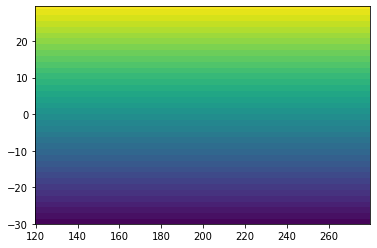

In [7]:
#check beta
plt.contourf(XU,YU,betaU,40)
plt.show()

### building model

In [7]:
# boundary conditions -- walls have no velcoity


def BC(t):
    u[t, 0, :] = 0
    u[t, -1, :] = 0
    
    v[t,:, 0] = 0
    v[t,:, -1] = 0
    
    #h[t,:, 0] = h[t,:, 1]
    #h[t,:, -1] = h[t,:, -2]
    #h[t,0, :] = h[t,1, :]
    #h[t,-1, :] = h[t,-2, :]
    


In [8]:
def gauss(X,Y,nx,ny):
    return 1*(np.exp(-((X-nx/2)**2/(2*(10)**2) + (Y-ny/2)**2/(2*(10)**2))))

def centermean(data):
# Returns the four-point average of shape (ny-1, nx-1).    
    return 0.25*(data[:-1,:-1] + data[:-1,1:] + data[1:, :-1] + data[1:,1:])

def yavg(data):
#Average adjacent values in the y-dir of shape (ny-1, nx)
    return 0.5*(data[:,:-1] + data[:,1:])

#def xavg(data):
#Average adjacent values in the x-dir of shape (nx, ny-1)
#    return 0.5*(data[:-1,:] + data[1:,:])

def centered_average_uv(udata,vdata):
    ubar = centermean(udata)[:,:]  
    vbar = centermean(vdata)[:,:]  
    return ubar, vbar

def d_dx(data):
    return (data[1:,:] - data[:-1,:]) / dx

def d_dy(data):
    return (data[:,1:] - data[:,:-1]) / dy

def div(u,v):
    return d_dx(u)[:,:] + d_dy(v)[:,:] # shifted over

def leapfrog(fulldata,t):
    if (fulldata[t].shape) == [X,Y]:
        fulldata[t] = fulldata[t] + 0.6*(fulldata[t-1] - (2.*fulldata[t]) + fulldata[t+1])
    elif (fulldata[t].shape) == [XU,YU]:
        fulldata[t,1:-1,:] = fulldata[t,1:-1,:] + 0.6*(fulldata[t-1,1:-1,:] - (2.*fulldata[t,1:-1,:]) + fulldata[t+1,1:-1,:])
    else:
        fulldata[t,:,1:-1] = fulldata[t,:,1:-1] + 0.6*(fulldata[t-1,:,1:-1] - (2.*fulldata[t,:,1:-1]) + fulldata[t+1,:,1:-1])
    return fulldata[t]

In [9]:
# initial pertubation
h[1] = gauss(X, Y,400,0)
print(np.max(h[1]))

1.0


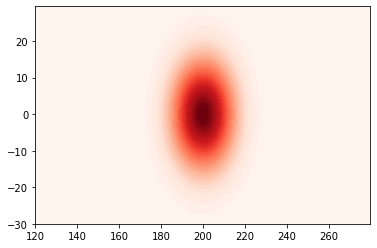

In [10]:
# see what t=0 inital pertubation looks like
plt.contourf(X,Y,h[1],np.linspace(0,1,40),cmap='Reds')
plt.show()

In [11]:
# test first timestep

t=1

BC(t)

print('h shape: '+str(h[t].shape))
print('u shape: '+str(u[t,1:-1,:].shape))
print('v shape: '+str(v[t,:,1:-1].shape))

ubar,vbar = centered_average_uv(u[t],v[t]) 

divuv = div(u[t],v[t])

dh_dx = d_dx(h[t])[:,:]
dh_dy = d_dy(h[t])[:,:] 

bU = betaU[1:-1,:]
bV = betaV[:,1:-1]

print('ubar and vbar shape: '+ str(ubar.shape)+str(vbar.shape))
print('div shape: '+ str(divuv.shape))
print('dhdx and dhdy shape: '+ str(dh_dx.shape)+str(dh_dy.shape))
print('betaU,betaV :' + str(bU.shape)+str(bV.shape))

h[t+1] = (h[t-1]*(1 - 2.*alpha*dt)) - (2.*dt*D*divuv)
u[t+1,1:-1,:] = u[t-1,1:-1,:] - (2.*dt*gamma1*u[t-1,1:-1,:]) - (2.*dt*g*dh_dx) + (2.*dt*(f0+bU)*vbar)
v[t+1,:,1:-1] = v[t-1,:,1:-1] - (2.*dt*gamma2*v[t-1,:,1:-1]) - (2.*dt*g*dh_dy) - (2.*dt*(f0+bV)*ubar)

h shape: (320, 120)
u shape: (319, 120)
v shape: (320, 119)
ubar and vbar shape: (320, 119)(319, 120)
div shape: (320, 120)
dhdx and dhdy shape: (319, 120)(320, 119)
betaU,betaV :(319, 120)(320, 119)


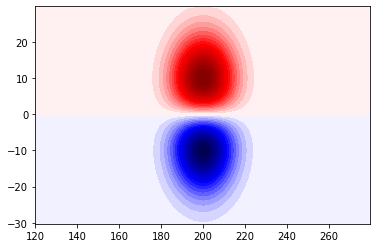

In [12]:
# see whatinital pertubation response looks like

plt.contourf(XV,YV,v[2],40,cmap='seismic')
plt.show()

In [13]:
for t in range(2,nt-1):
    if t % 500 ==0:
        print(t)
     
    BC(t)
    
    # temporal smoothing
    if t%17 ==0: # every 17 timesteps
        #print('smoothing')
        
        # temporal smoothing
        h[t+1] = h[t+1] + 0.5*(h[t]+h[t-1]) 
        u[t+1,1:-1,:] = u[t+1,1:-1,:] + 0.5*(u[t,1:-1,:]+u[t-1,1:-1,:])
        v[t+1,:,1:-1] = v[t+1,:,1:-1] + 0.5*(v[t,:,1:-1]+v[t-1,:,1:-1])
        
        #u[t] = leapfrog(u,t) 
        #v[t] = leapfrog(v,t) 
        #h[t] = leapfrog(h,t) 

         # spatial smoothing   

        u[t+1]=gaussian_filter(u[t+1],sigma=mu)
        v[t+1]=gaussian_filter(v[t+1],sigma=mu)
        h[t+1]=gaussian_filter(h[t+1],sigma=mu)

    else:

        ubar,vbar = centered_average_uv(u[t],v[t]) 

        divuv = div(u[t],v[t])

        dh_dx = d_dx(h[t])[:,:]
        dh_dy = d_dy(h[t])[:,:] 

        bU = betaU[1:-1,:]
        bV = betaV[:,1:-1]

        h[t+1] = (h[t-1]*(1 - 2.*alpha*dt)) - (2.*dt*D*divuv)
        u[t+1,1:-1,:] = u[t-1,1:-1,:] - (2.*dt*gamma1*u[t-1,1:-1,:]) - (2.*dt*g*dh_dx) + (2.*dt*(f0+bU)*vbar)
        v[t+1,:,1:-1] = v[t-1,:,1:-1] - (2.*dt*gamma2*v[t-1,:,1:-1]) - (2.*dt*g*dh_dy) - (2.*dt*(f0+bV)*ubar)

        #u[t] = leapfrog(u,t) 
        #v[t] = leapfrog(v,t) 
        #h[t] = leapfrog(h,t) 

         # spatial smoothing   

        u[t+1]=gaussian_filter(u[t+1],sigma=mu)
        v[t+1]=gaussian_filter(v[t+1],sigma=mu)
        h[t+1]=gaussian_filter(h[t+1],sigma=mu)


500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500


### PLOTTING (the biggest mess of the code)

In [14]:
cmap1,cmap2 = 'Reds','seismic'

ulevs = 40#np.arange(-.025,0.025+.001,.001)

0.00142998807736855 -0.0014181999756856243


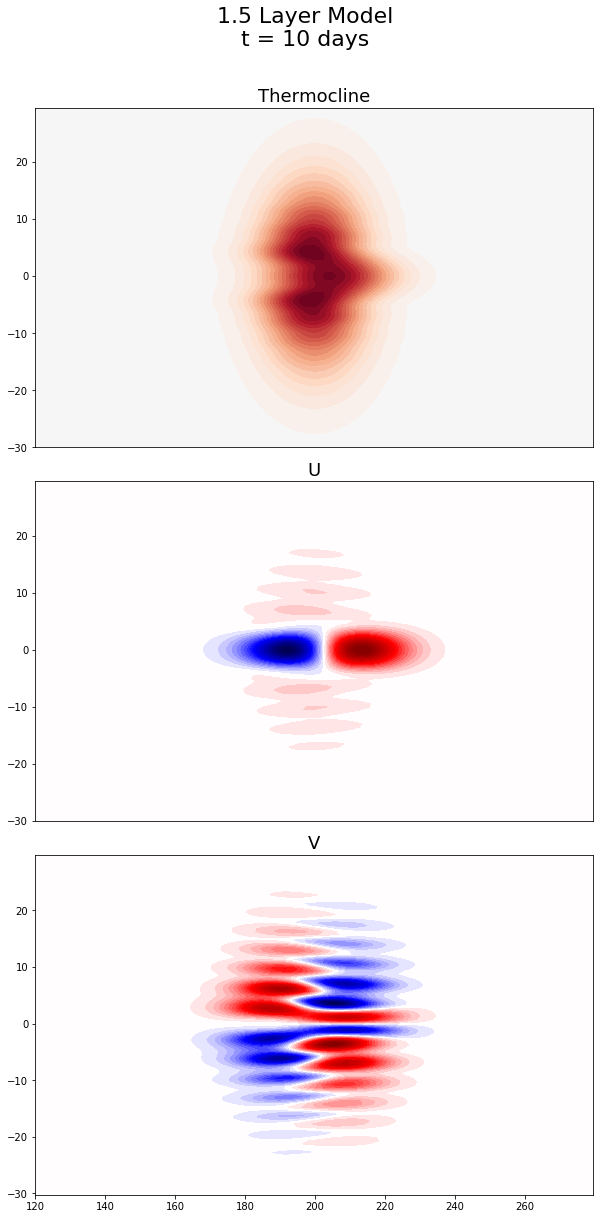

0.0012924662216930538 -0.0012972929411823775


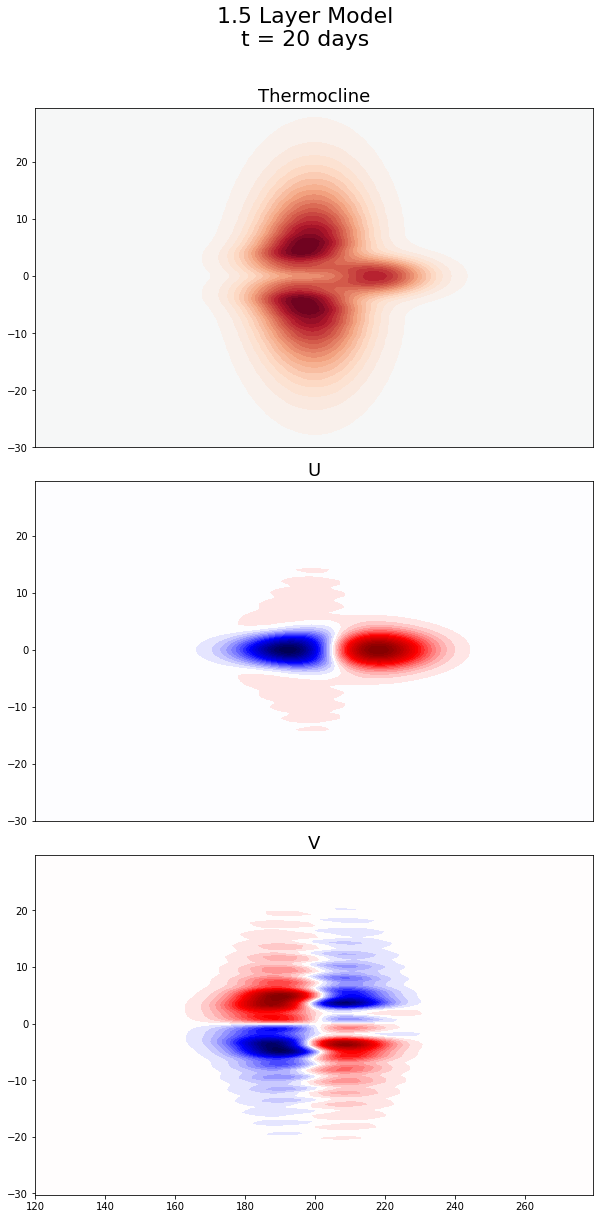

0.0008241638581387501 -0.0008567825377742906


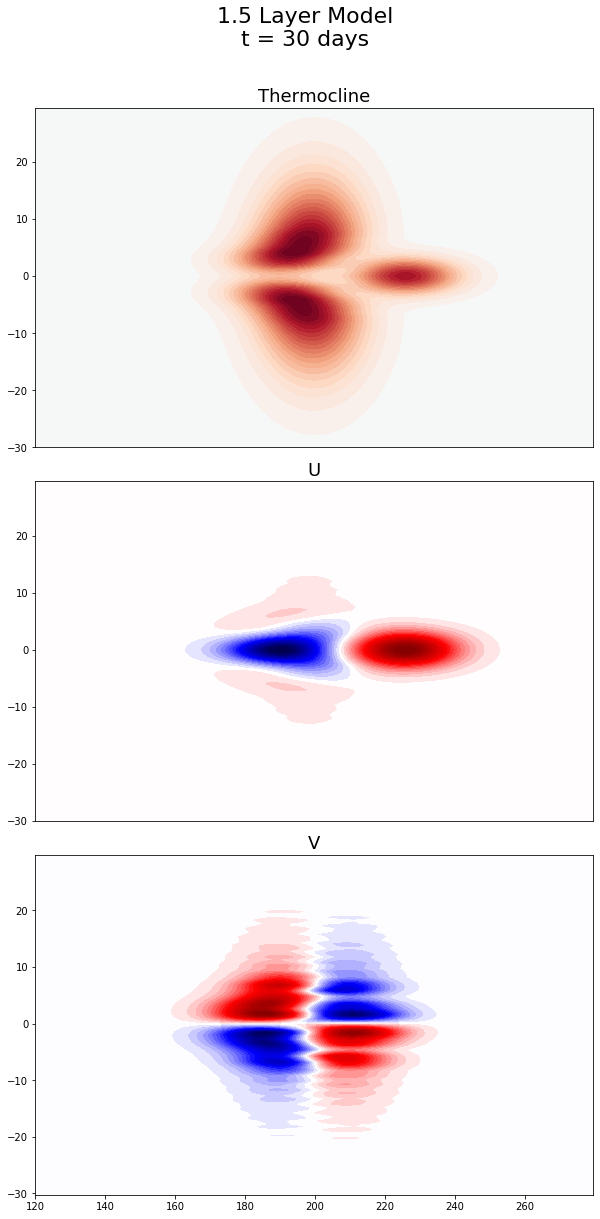

0.0005065356951238278 -0.0005421603499065244


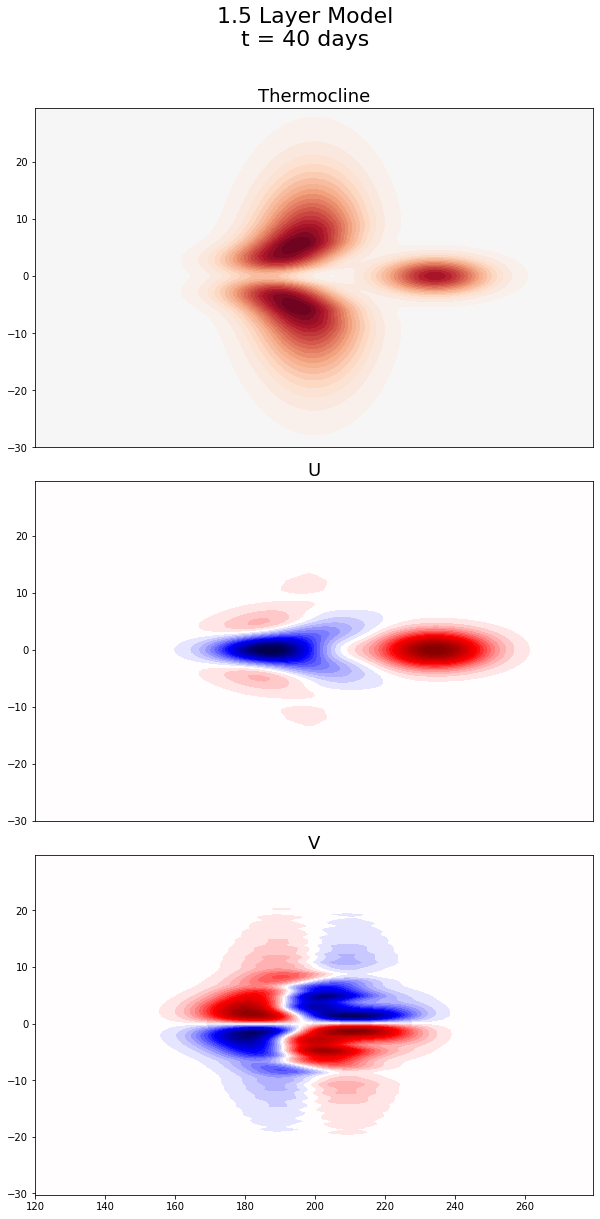

0.00031128352078688517 -0.0003412049071178011


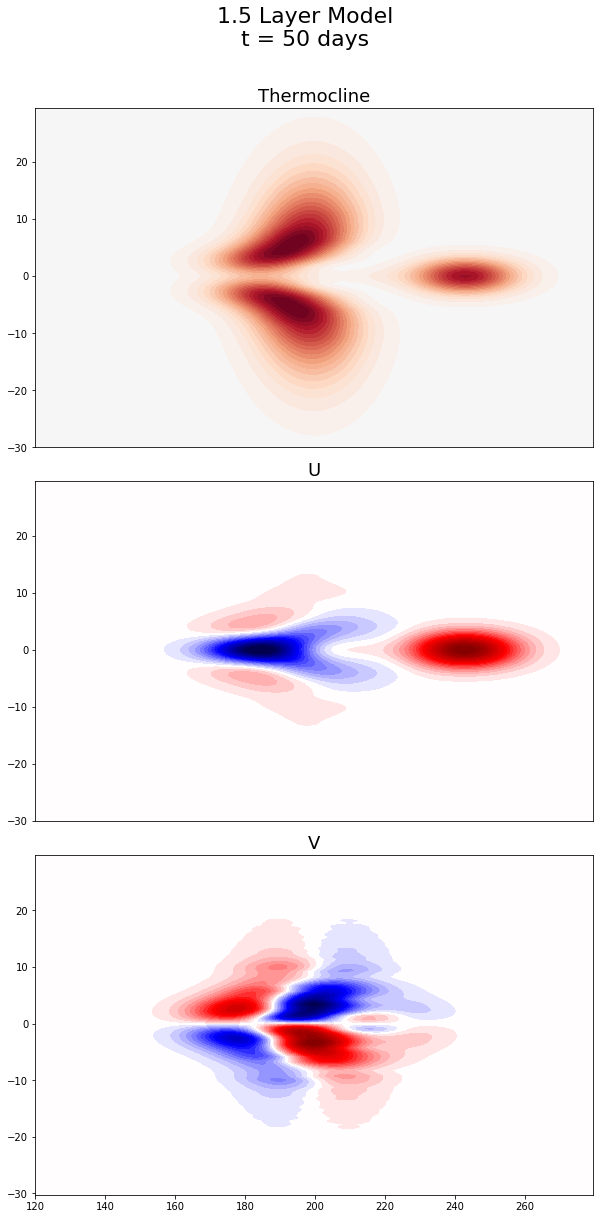

0.00019098766623273128 -0.00021567048076376091


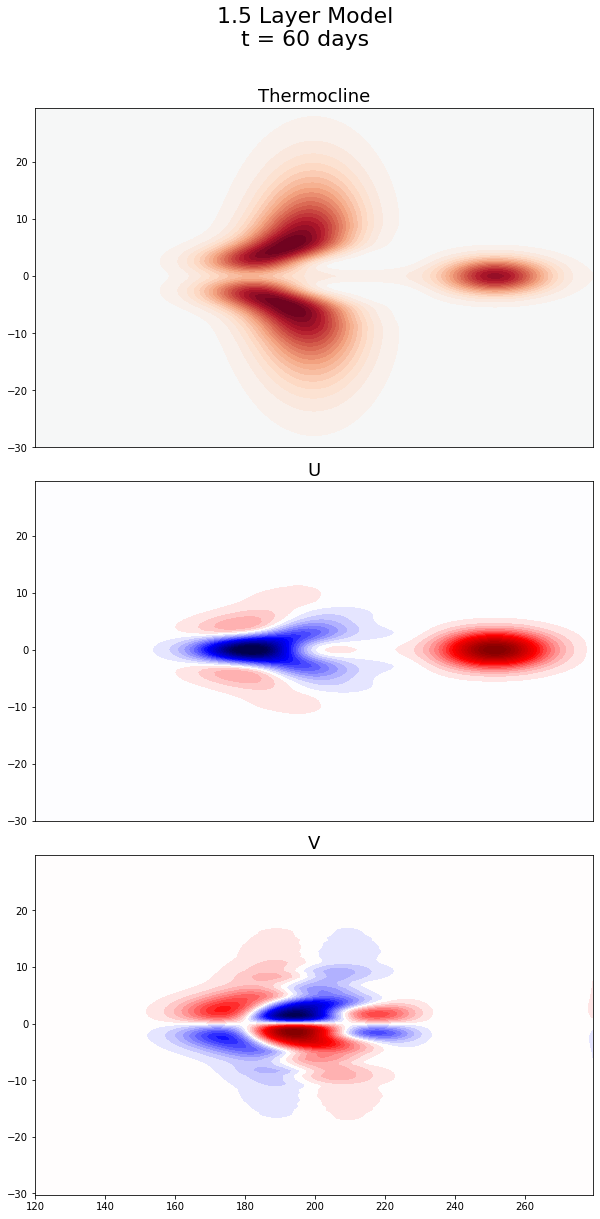

0.00011730530936064068 -0.00013718418865965717


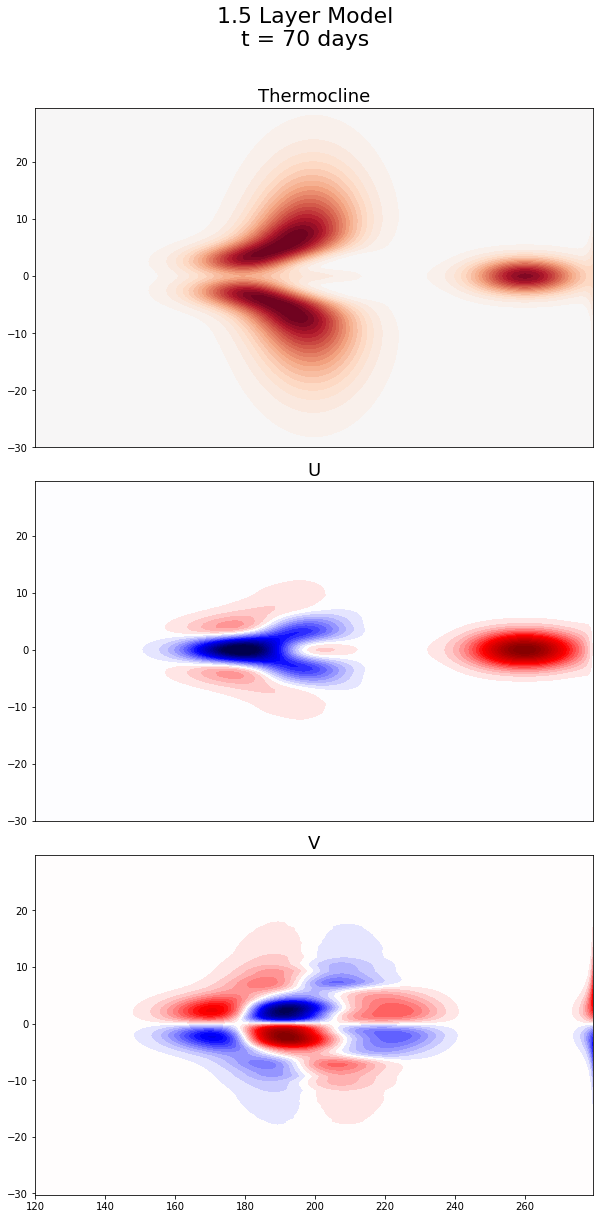

7.162177665663943e-05 -8.694128417990009e-05


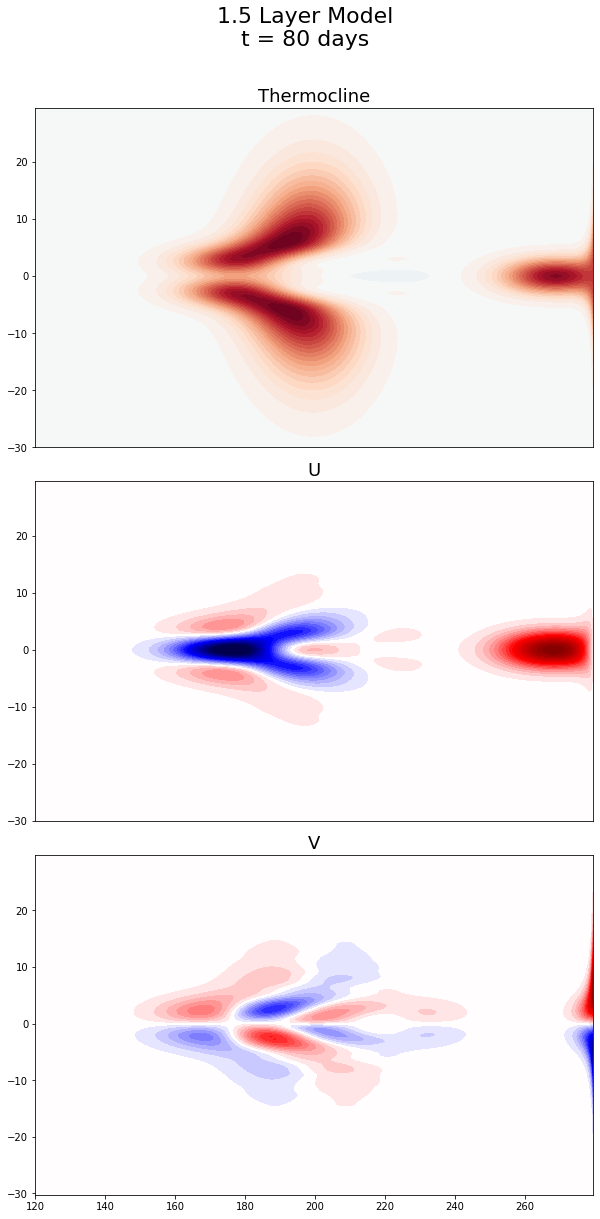

3.289825434301086e-05 -5.484378404232708e-05


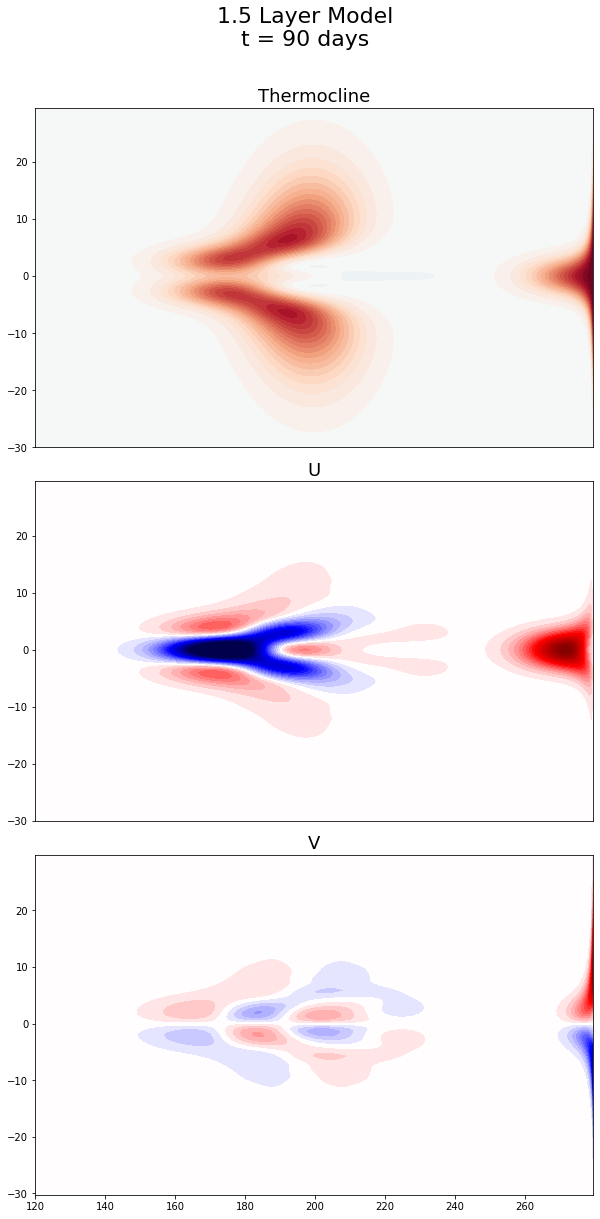

7.185605329281819e-06 -3.45601018029596e-05


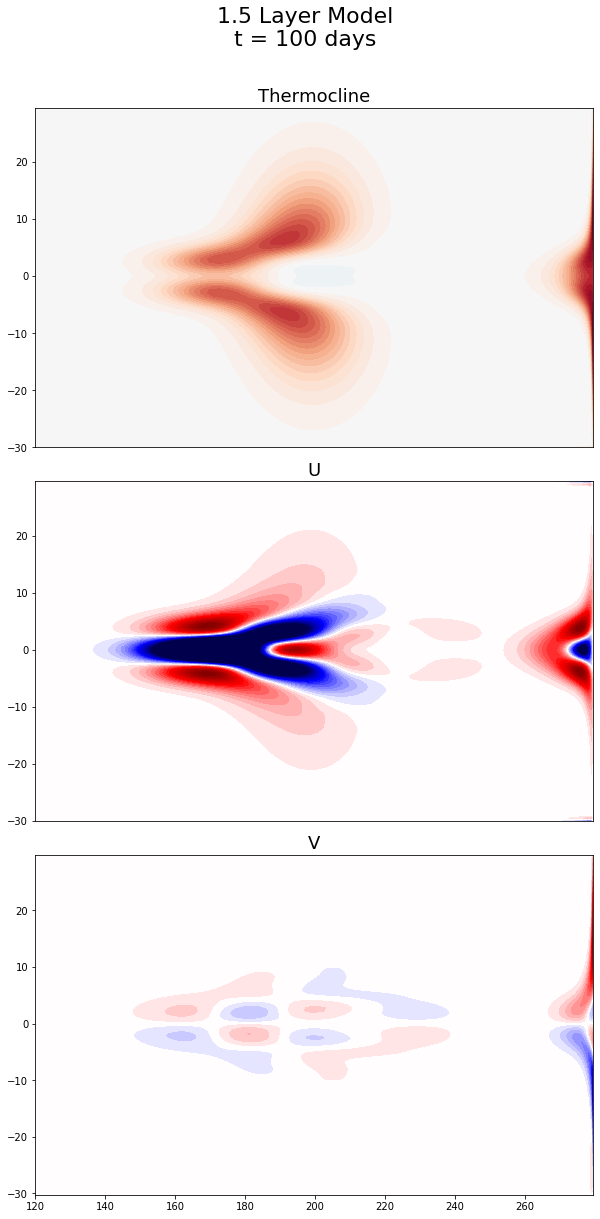

4.8301187674664845e-06 -2.171849316009525e-05


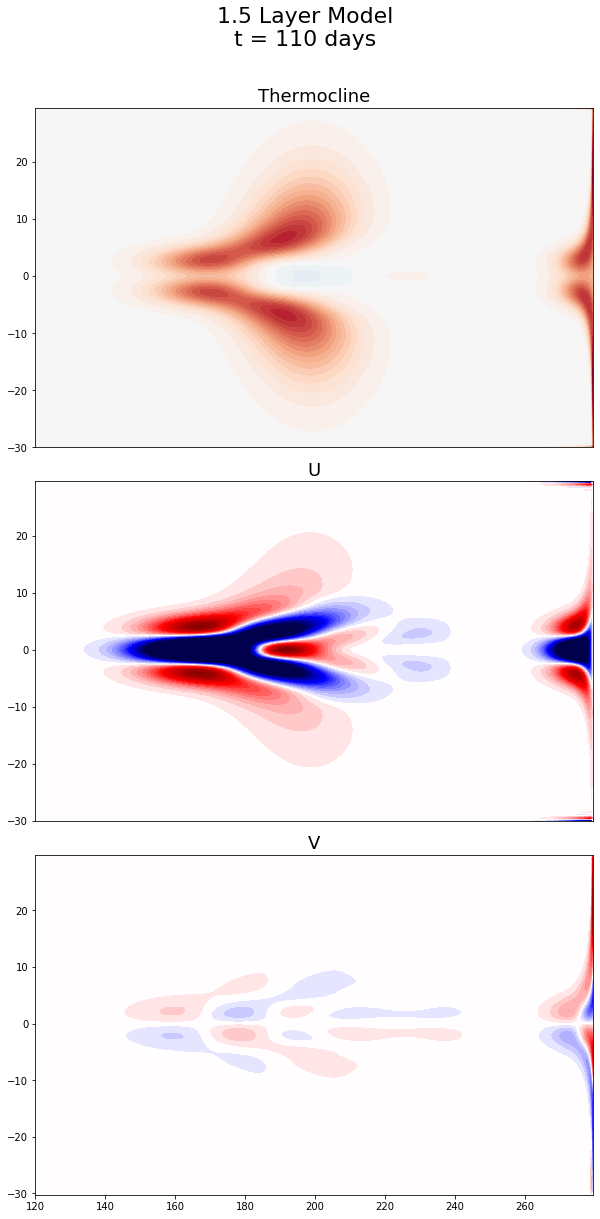

3.4481054521324767e-06 -1.3588449977360062e-05


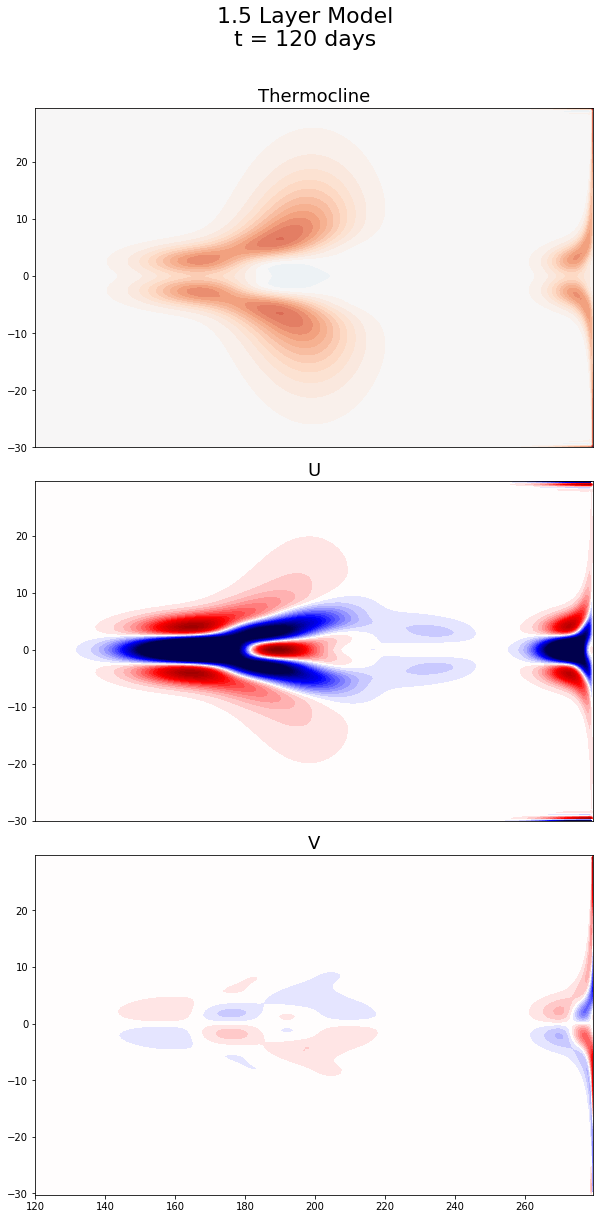

2.4029443458150847e-06 -8.477372970504103e-06


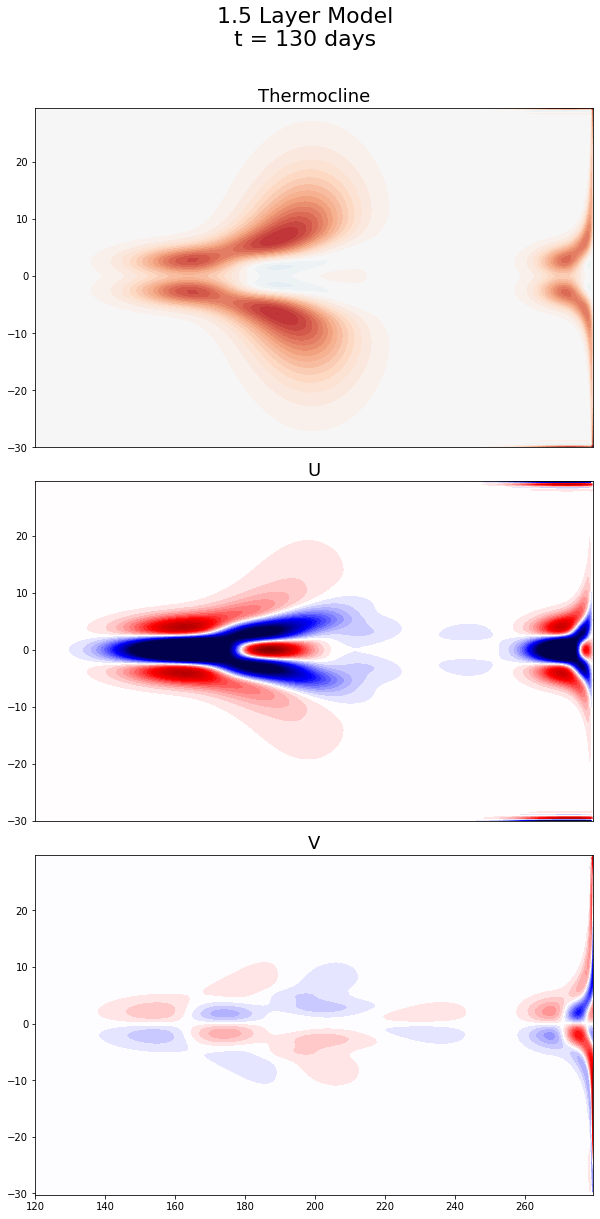

1.6348178042093402e-06 -5.271859968522626e-06


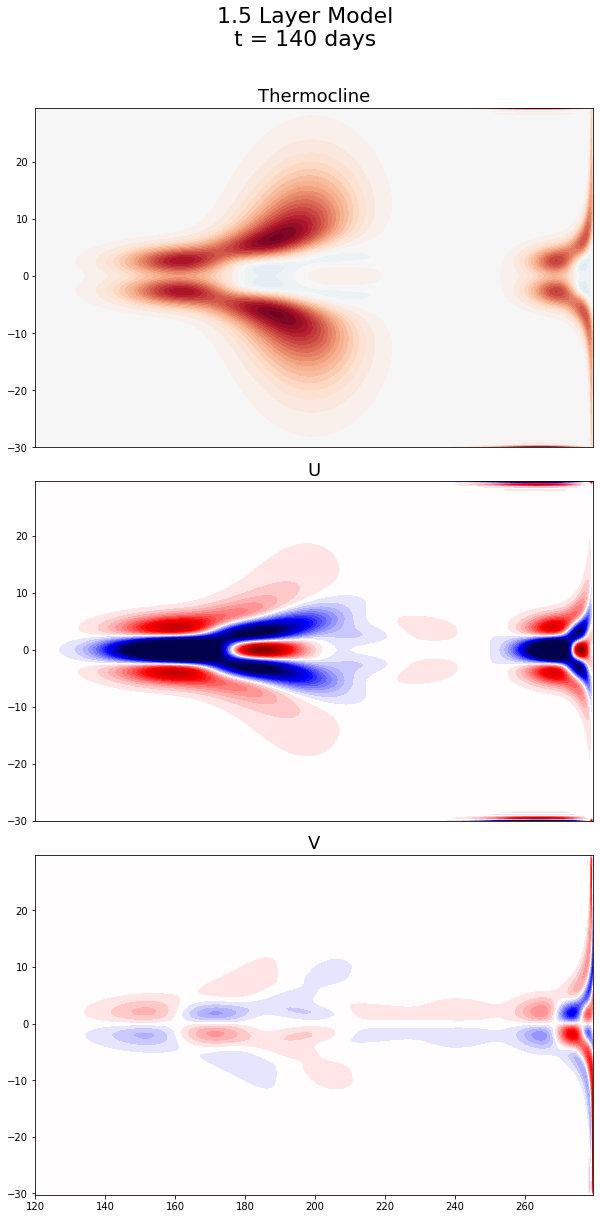

1.4273130879926201e-06 -3.271737070301584e-06


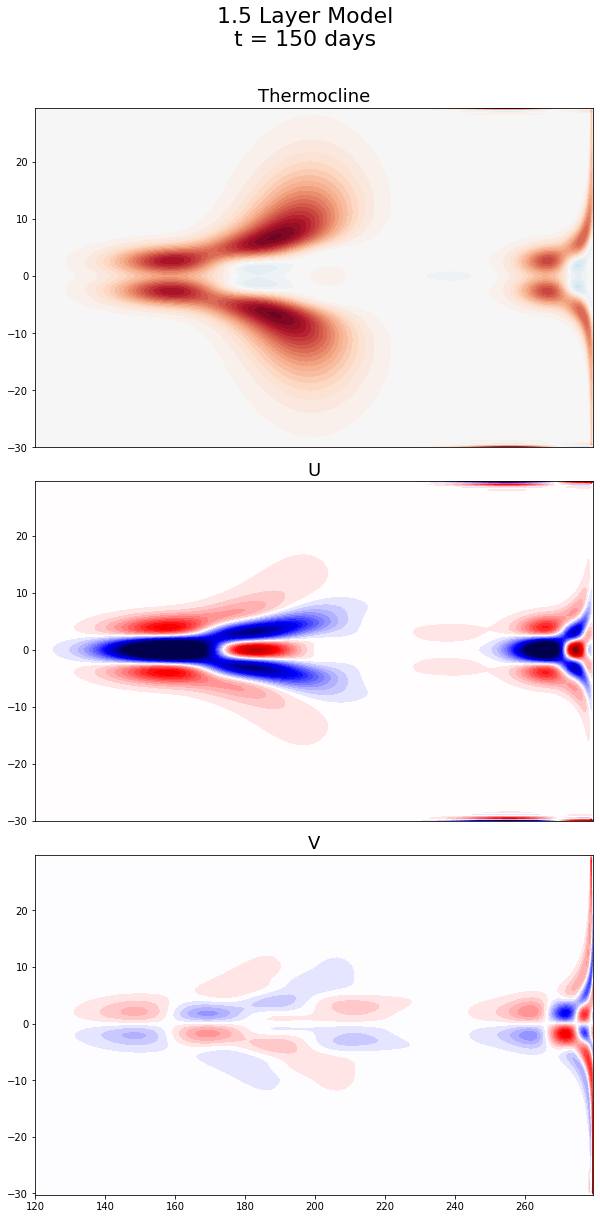

9.729613167860084e-07 -2.0221934293170513e-06


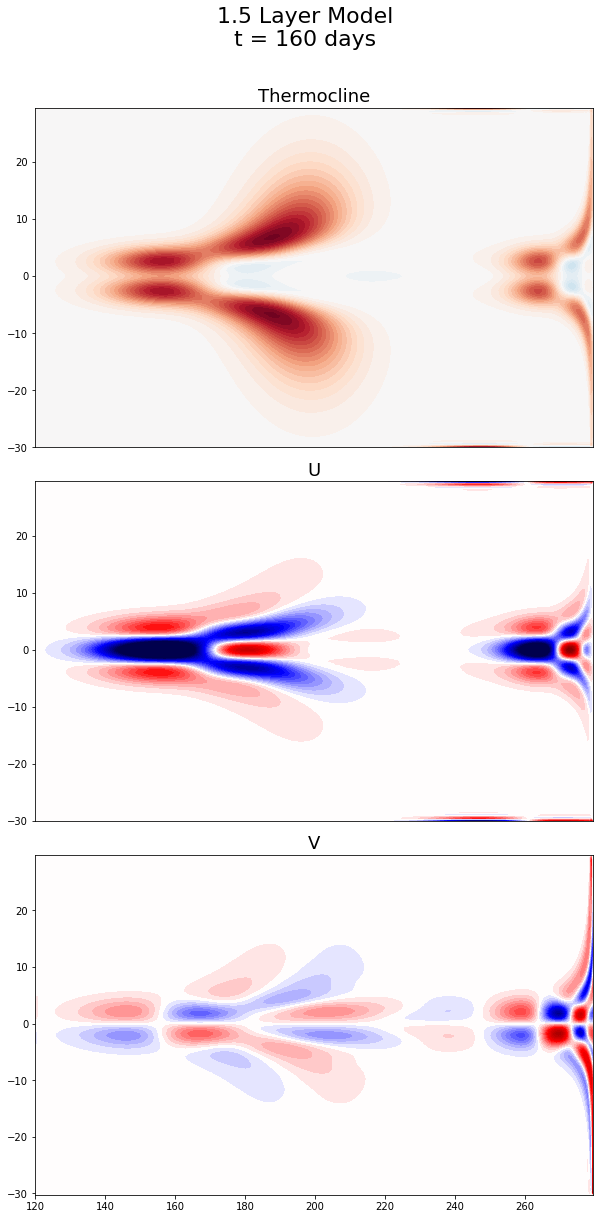

6.318170632105608e-07 -1.2484268727656651e-06


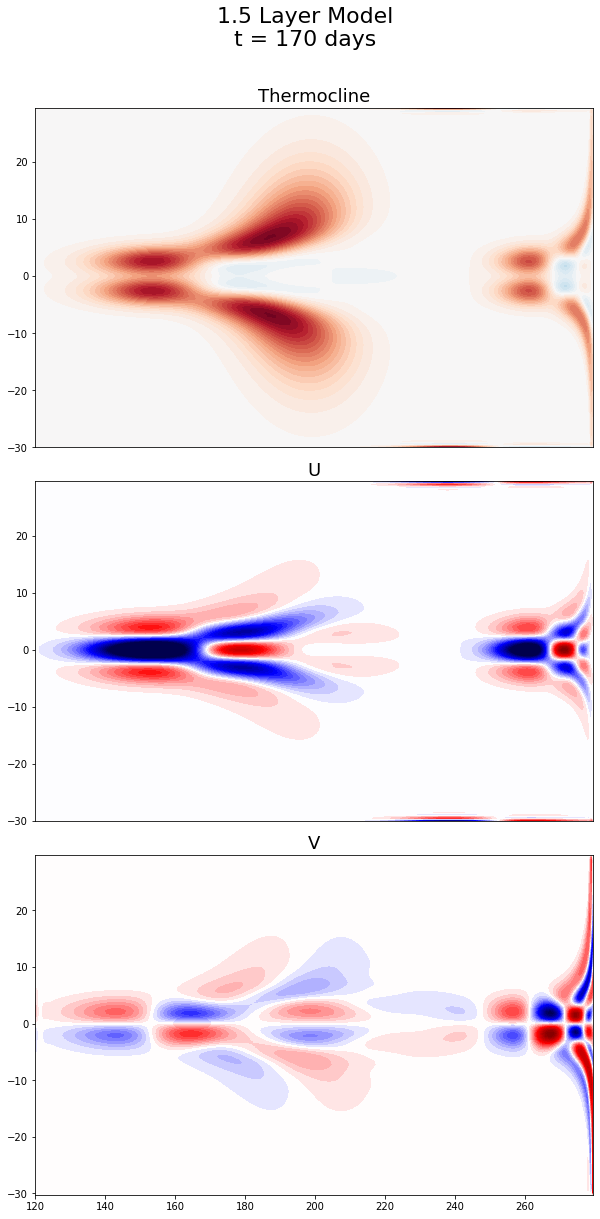

3.842862446795101e-07 -7.70069720128947e-07


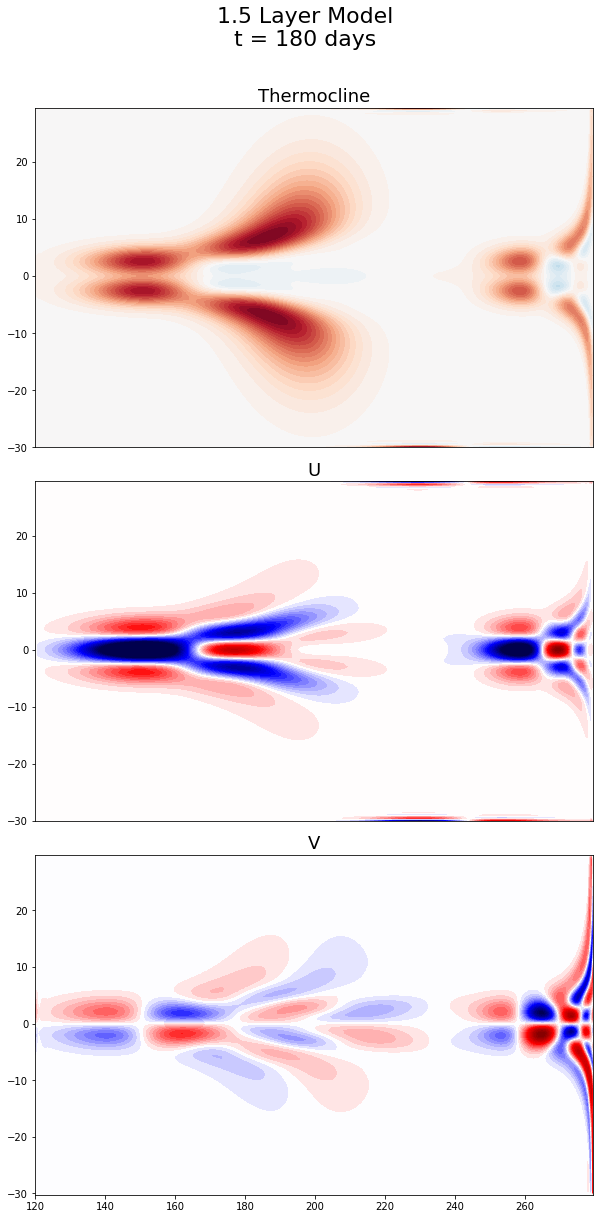

2.2184381635605973e-07 -4.732219276259445e-07


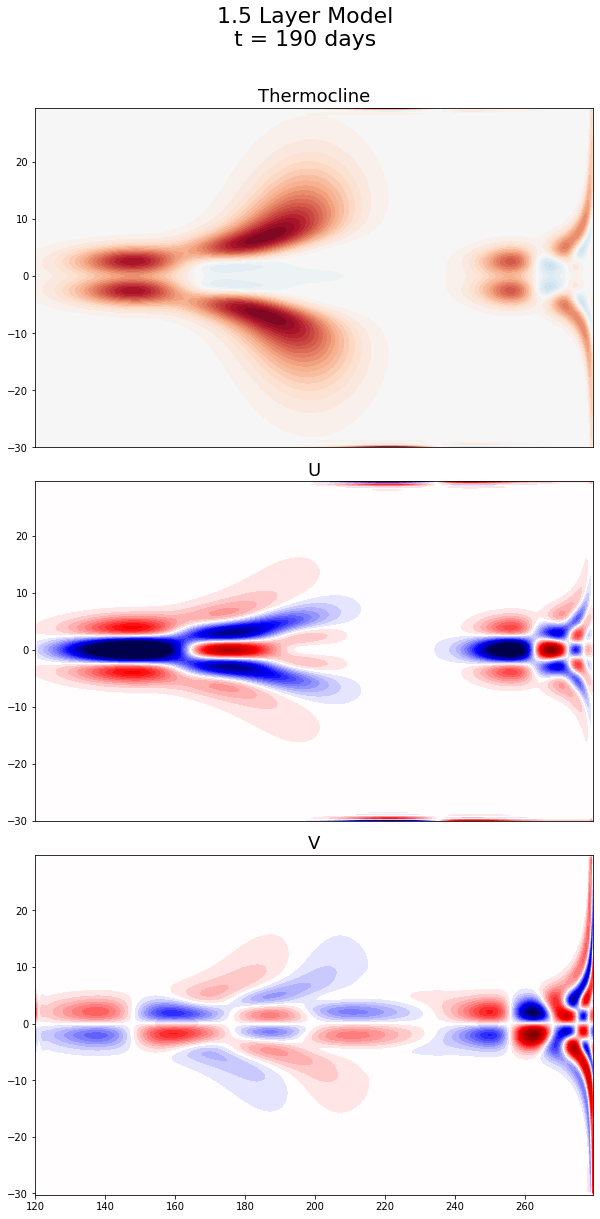

1.2498932841172636e-07 -2.900748994284389e-07


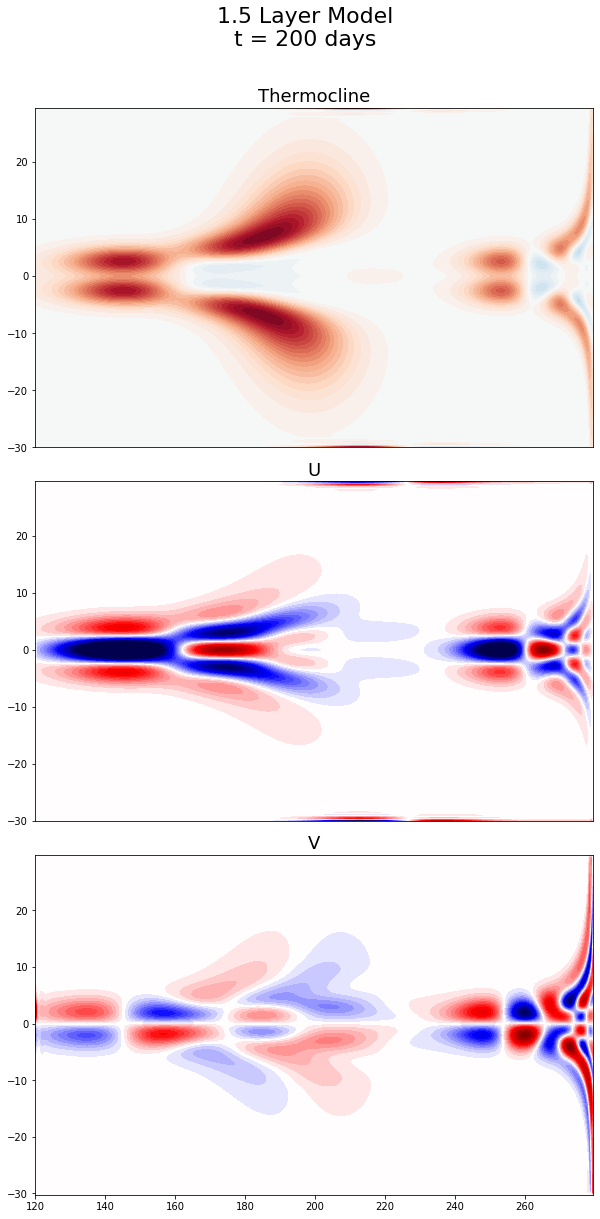

6.994292304263088e-08 -1.7684325592645077e-07


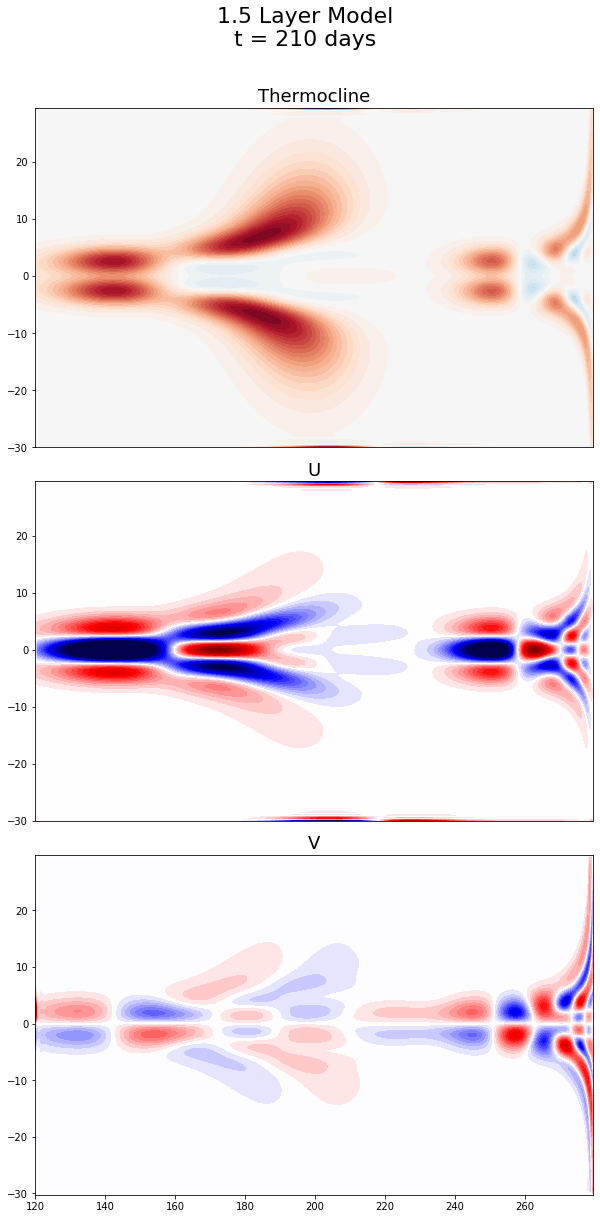

4.3406194154823283e-08 -1.070621796203921e-07


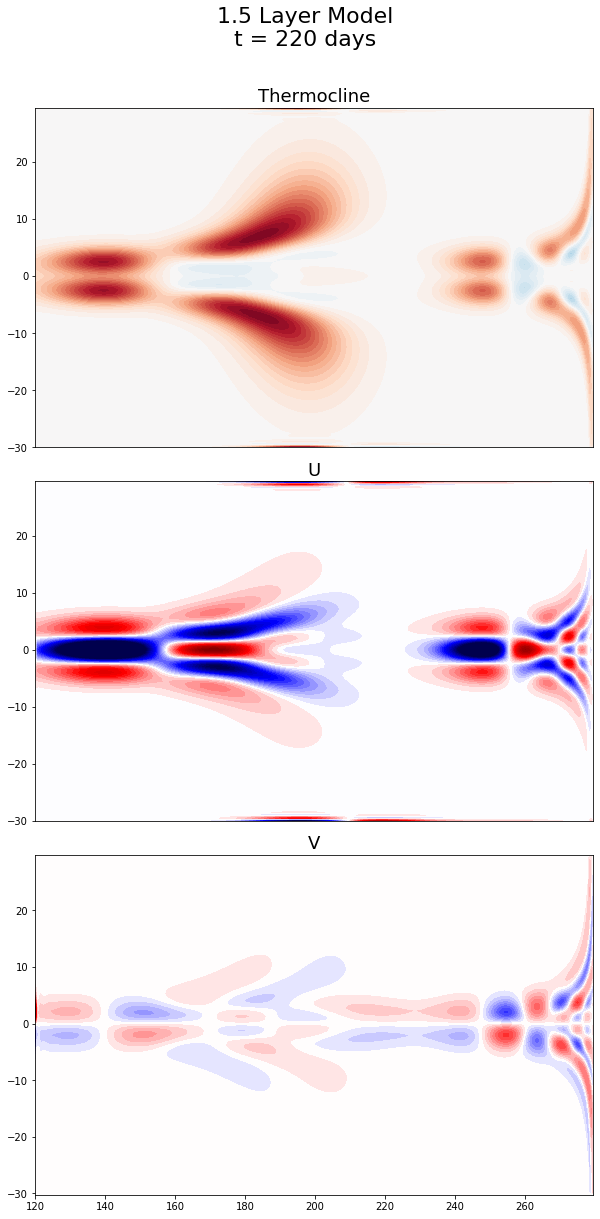

2.711570907849409e-08 -6.411946861939935e-08


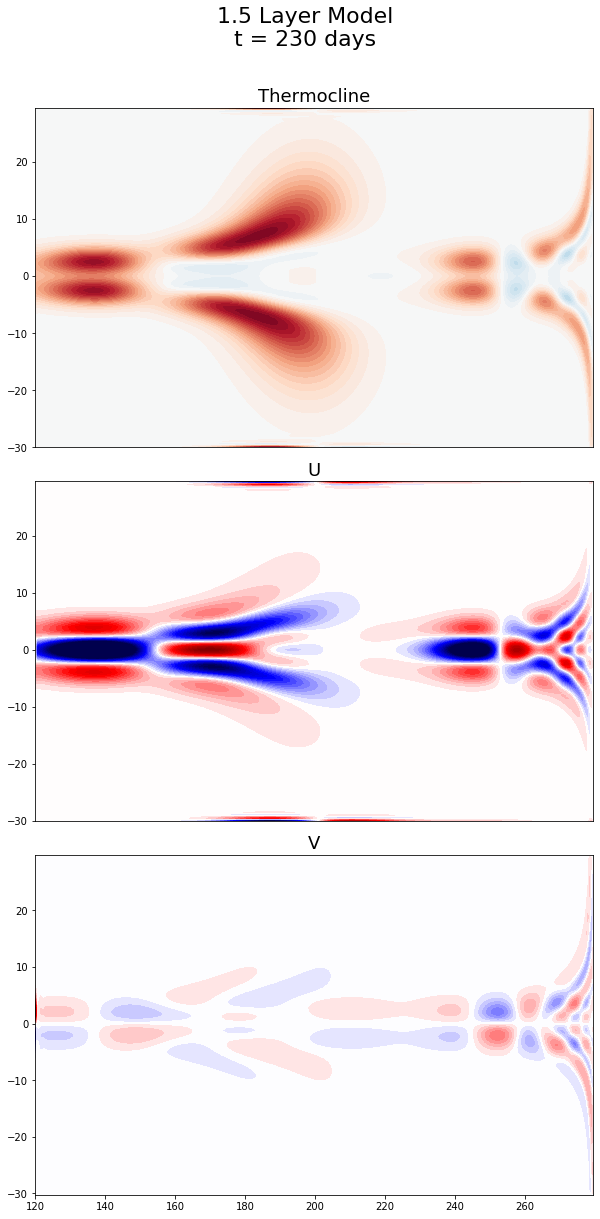

1.7066518803868706e-08 -3.7899673016433776e-08


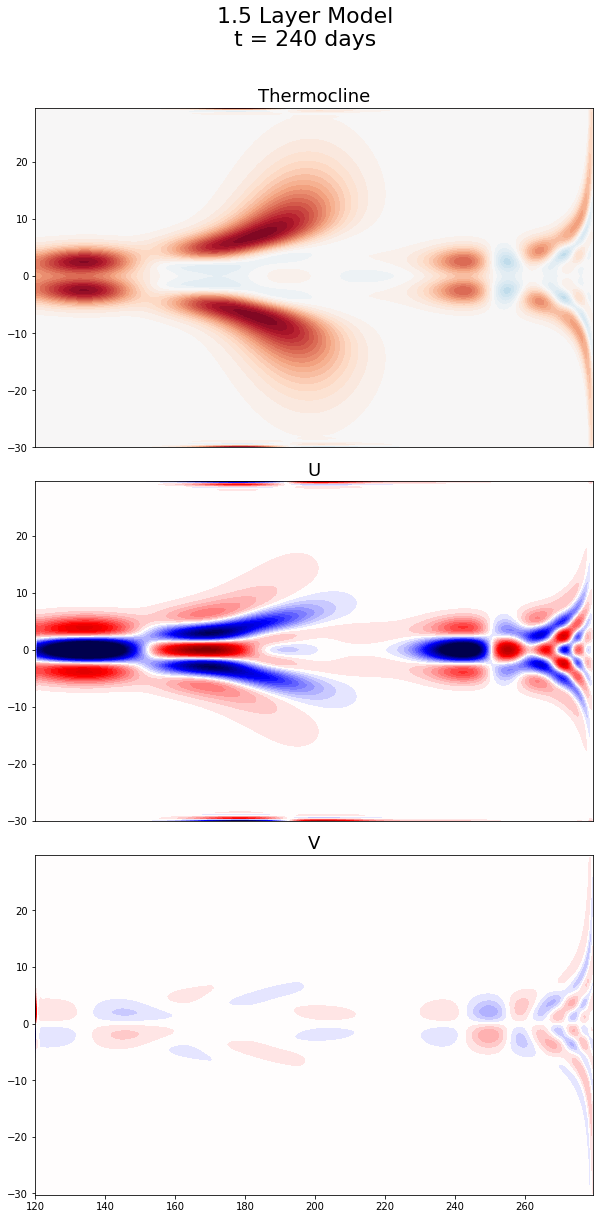

1.0839049381466143e-08 -2.200658005704708e-08


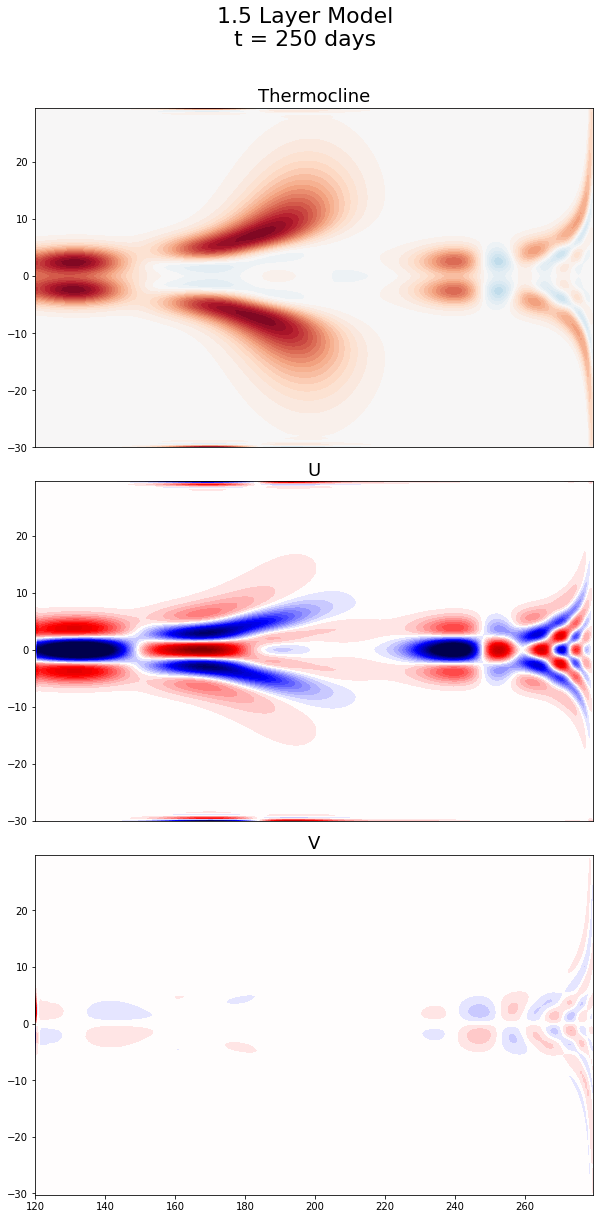

6.996932830695133e-09 -1.2579827680292052e-08


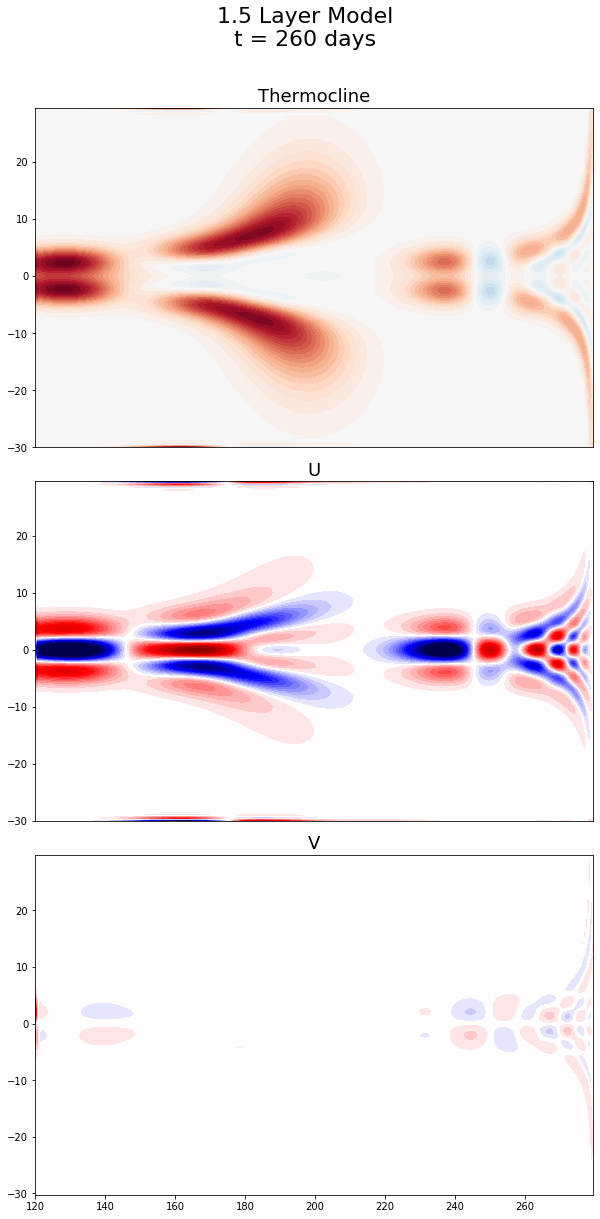

4.591444255526741e-09 -7.629005353070815e-09


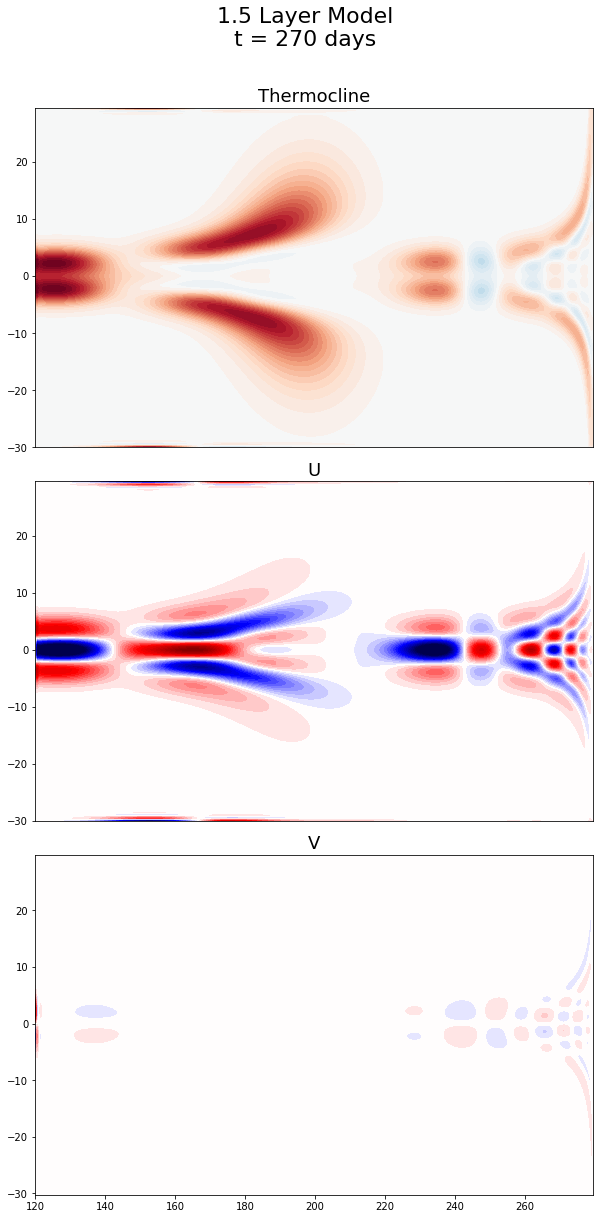

3.0585336157080607e-09 -5.5633394866973804e-09


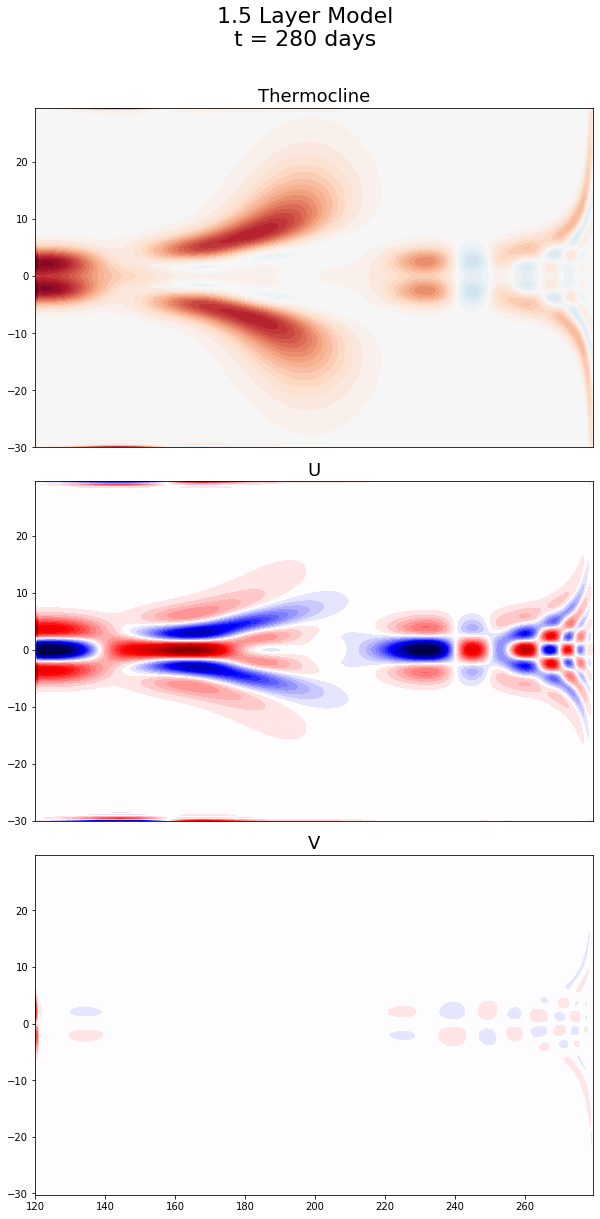

2.05751209254314e-09 -3.855374812544985e-09


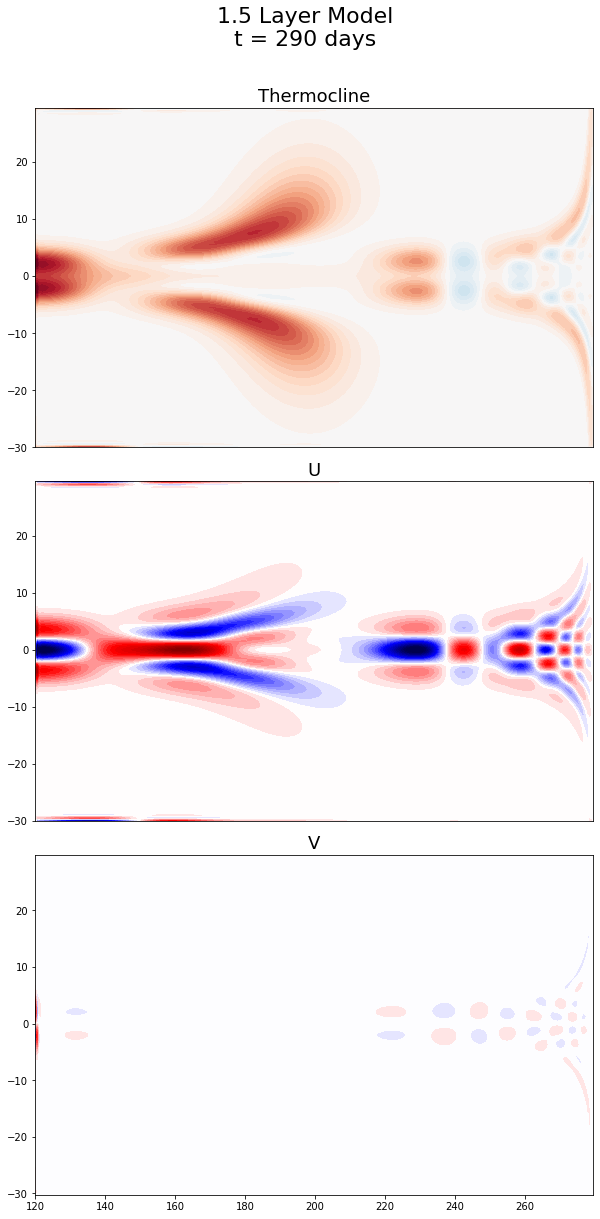

1.387391430027119e-09 -2.535873093885883e-09


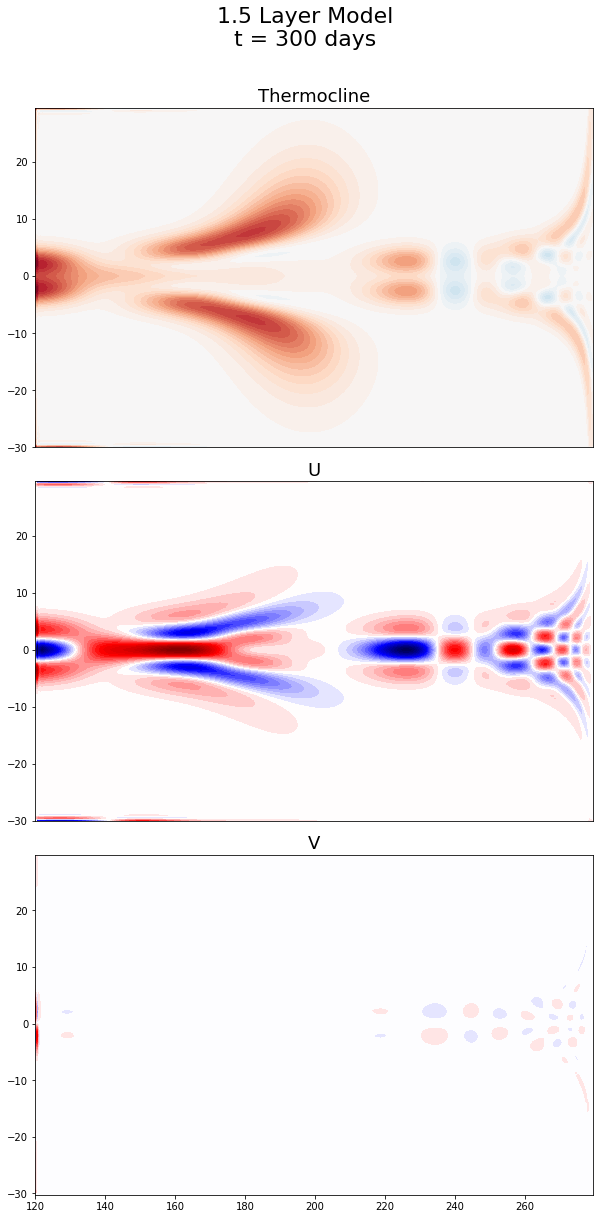

9.274082529744165e-10 -1.5766423355973849e-09


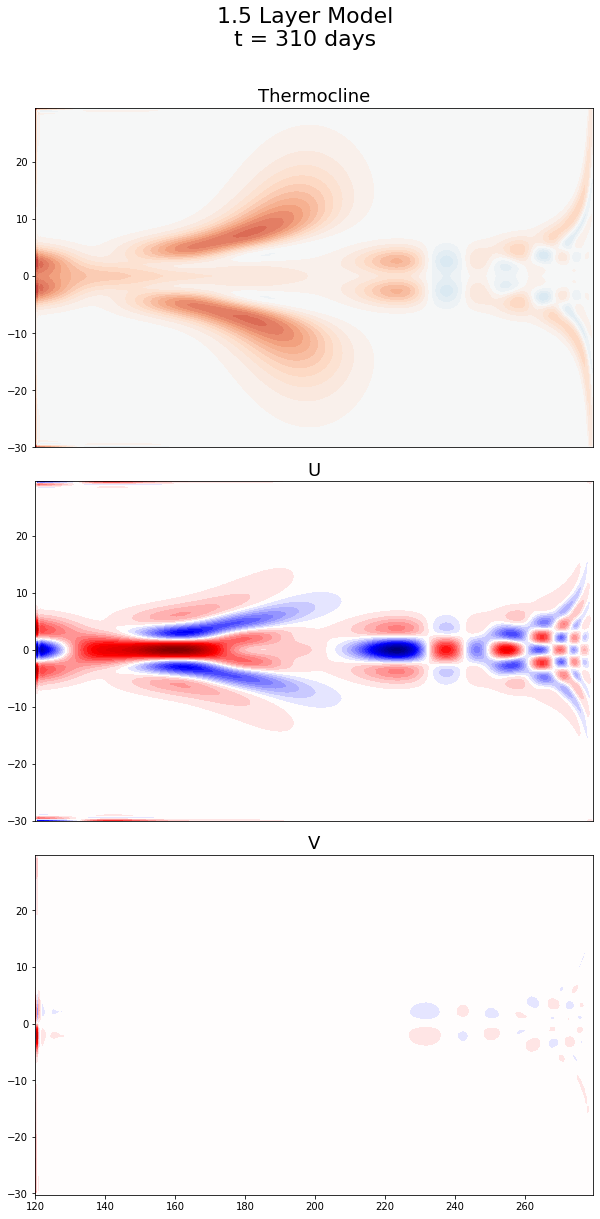

6.096481399757136e-10 -9.116002105350742e-10


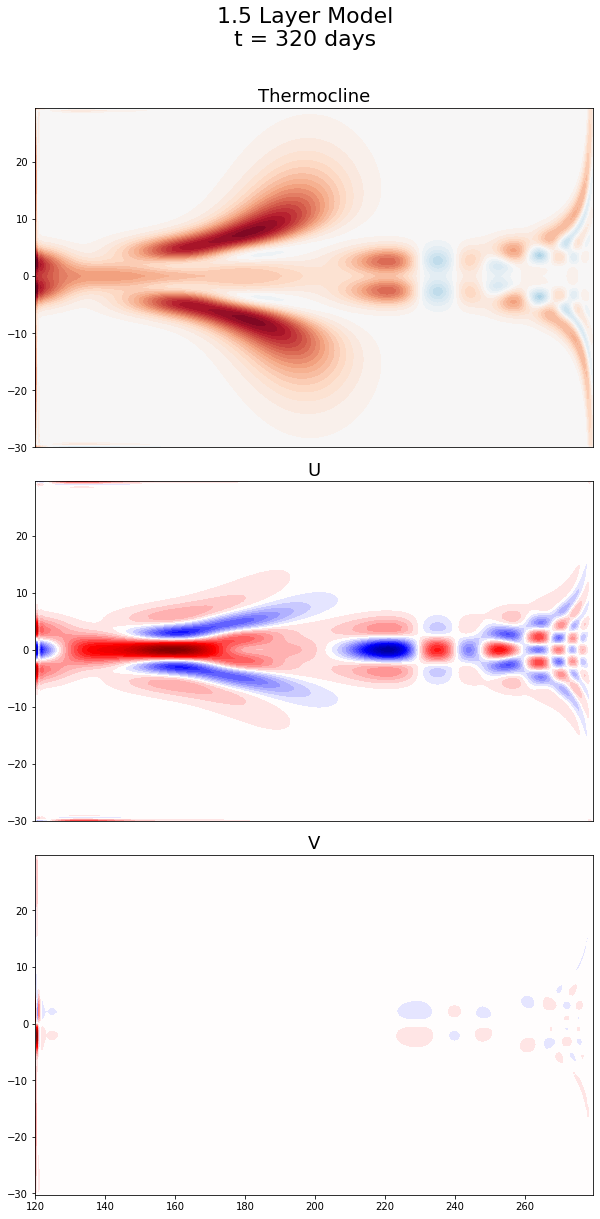

3.903870588017117e-10 -4.610130824910023e-10


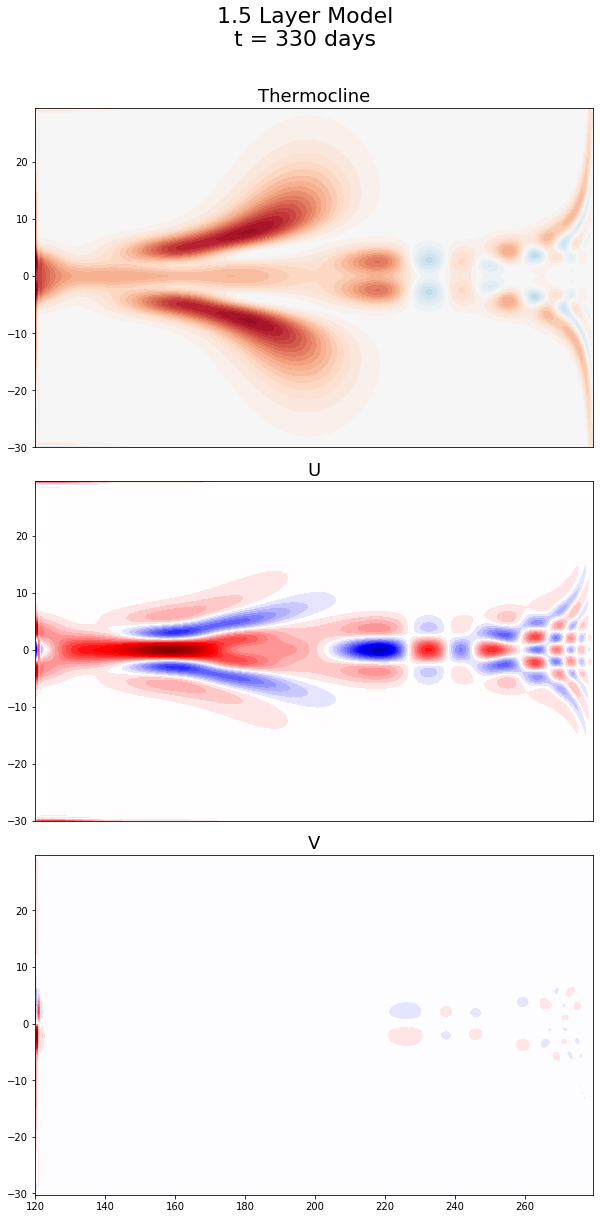

2.424189712058806e-10 -1.910455637539481e-10


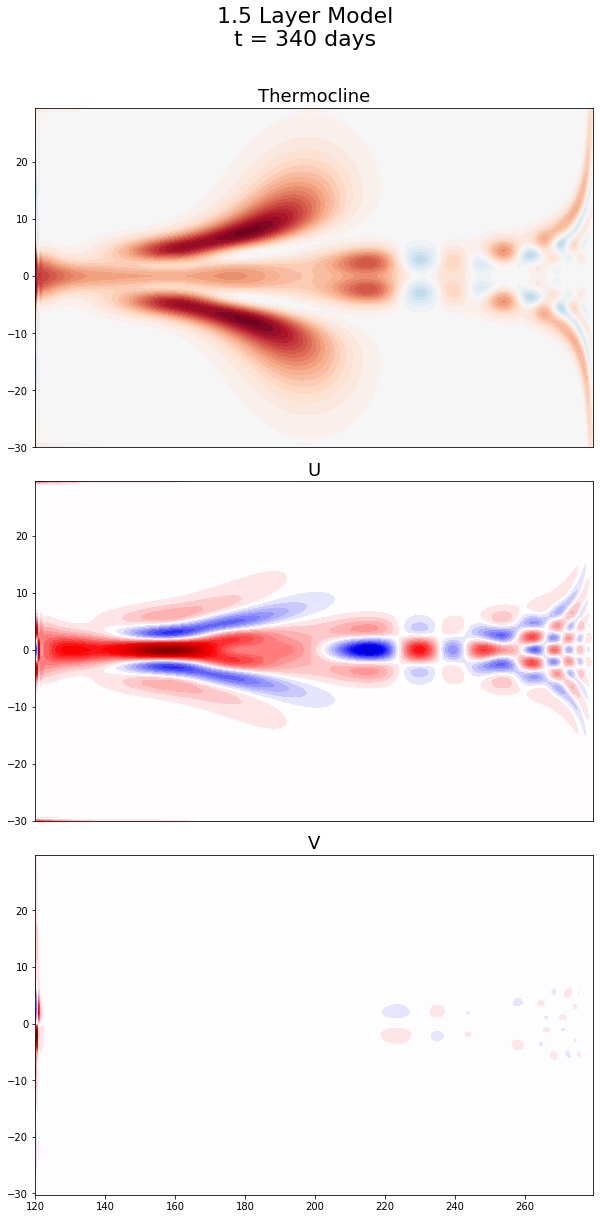

1.4604022377170068e-10 -8.707335403575764e-11


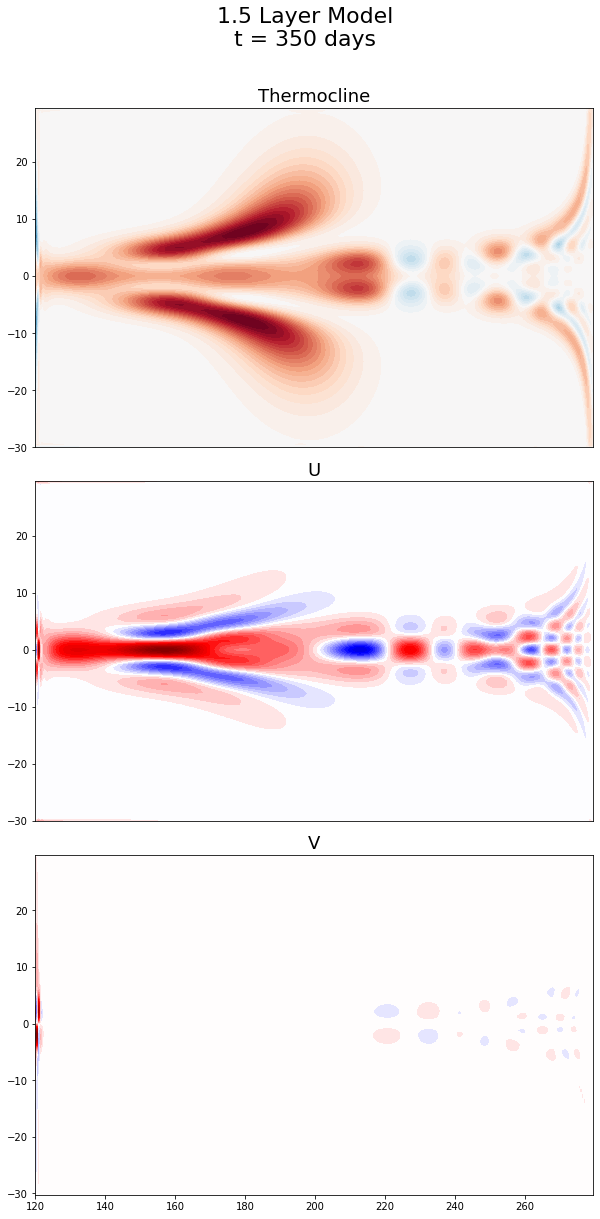

8.929415880269272e-11 -6.564127397173363e-11


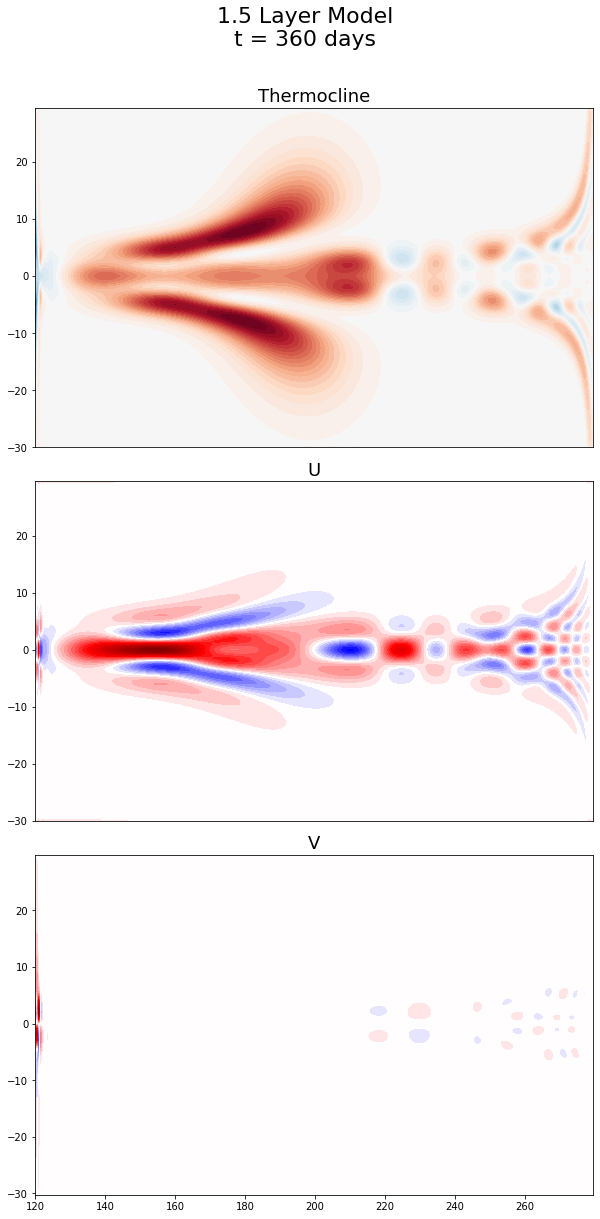

6.075649654751655e-11 -5.708144447123228e-11


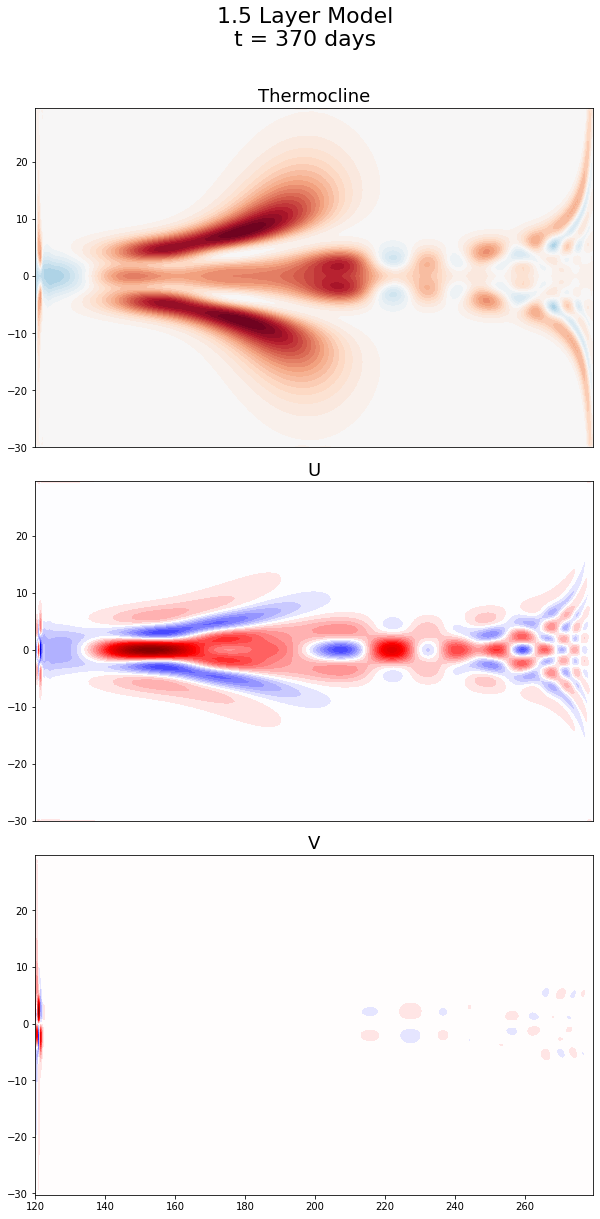

3.706437919012143e-11 -3.012559490141402e-11


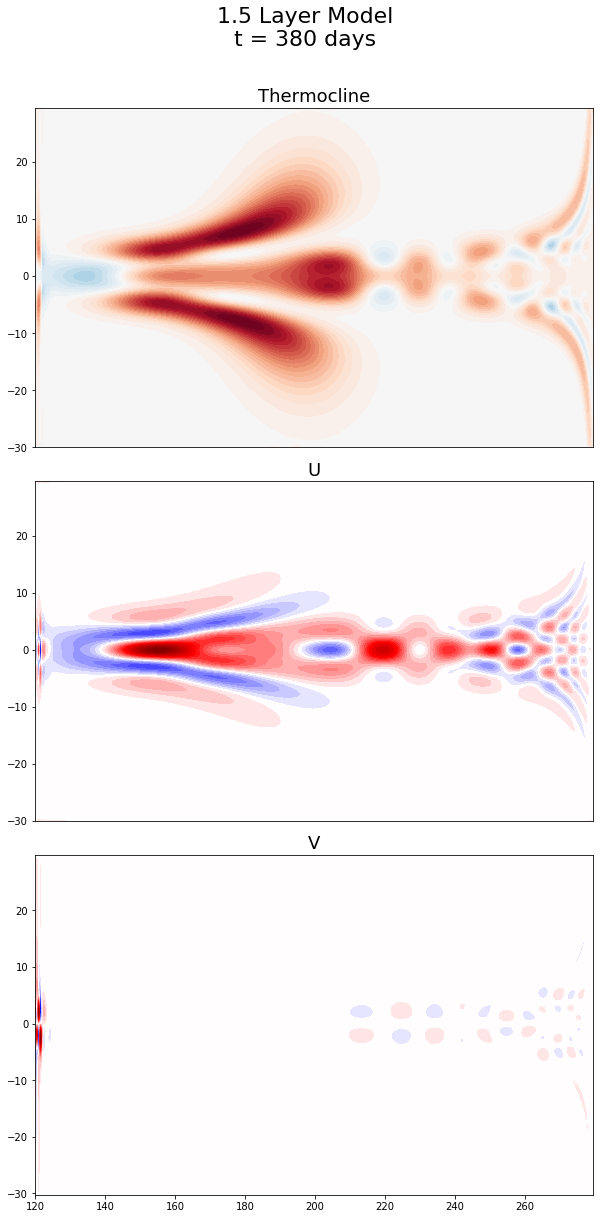

1.7109254470529105e-11 -1.2779624103213007e-11


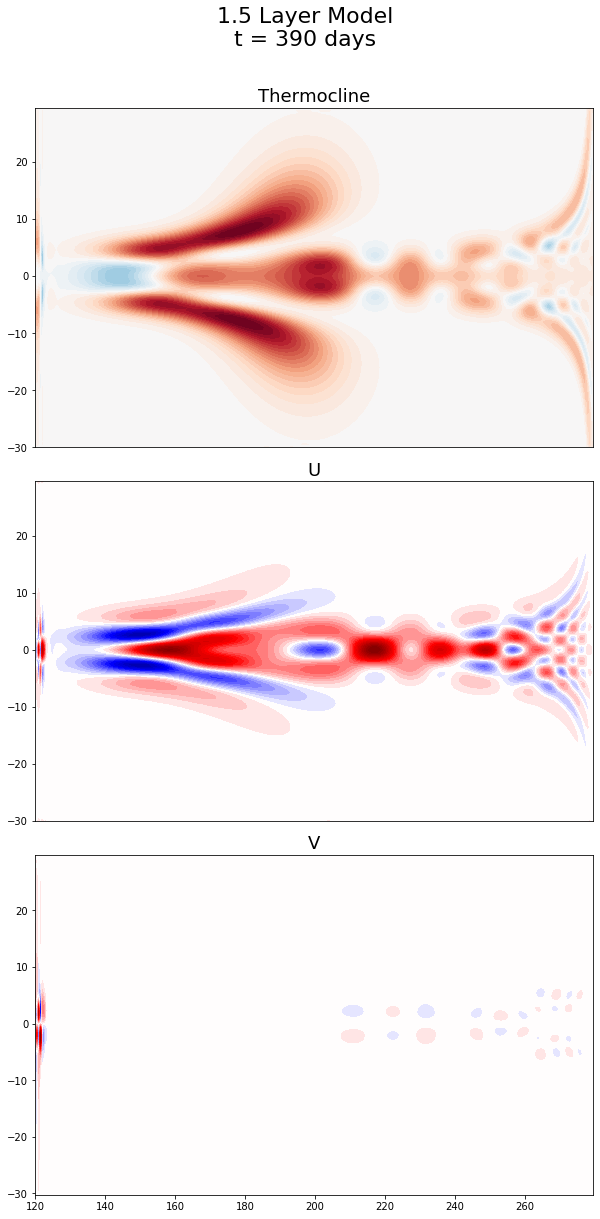

In [16]:
# see snapshots every 10 days
for idx in range(1,40):
    t=960*idx
    day= ((t*dt) / 86400.)
    uplot = u[t] #*(10**(-252))
    hplot = h[t] #*(10**(-252))
    vplot = v[t] #*(10**(-252))
    print(uplot.max(),uplot.min())

    fig = plt.figure(figsize=[10,20])
    st = fig.suptitle('1.5 Layer Model\nt = '+str(int(day))+' days' , fontsize=22)

    ax1 = fig.add_subplot(311)
    #y,x = np.meshgrid(y_pts,x_pts)
    cs=ax1.contourf(X,Y,hplot,np.linspace(-1*np.max(hplot),np.max(hplot),40,endpoint=True),cmap='RdBu_r',extend='both')
    ax1.set_title('Thermocline',fontsize=18)
    ax1.set_xticks([])

    ax2 = fig.add_subplot(312)
    #y,x = np.meshgrid(y_pts,x_pts)
    cs2=ax2.contourf(XU,YU,uplot,np.linspace(-1*np.max(uplot),np.max(uplot),40,endpoint=True),cmap=cmap2,extend='both')
    ax2.set_title('U',fontsize=18)
    ax2.set_xticks([])

    ax3 = fig.add_subplot(313)
    #y,x = np.meshgrid(y_pts,x_pts)
    cs3=ax3.contourf(XV,YV,vplot,np.linspace(-1*np.max(vplot),np.max(vplot),40,endpoint=True),cmap=cmap2,extend='both')
    ax3.set_title('V',fontsize=18)

    #cbaxes = fig.add_axes([0.92, 0.65, 0.025, 0.225])
    #cb = plt.colorbar(cs,orientation='vertical', cax = cbaxes)
    #cb.ax.set_ylabel('m',fontsize=14)
    #cb.ax.tick_params(labelsize=12) 

    #cbaxes2 = fig.add_axes([0.92, 0.26, 0.025, 0.225])
    #cb2 = plt.colorbar(cs2,orientation='vertical', cax = cbaxes2)
    #cb2.ax.set_ylabel('m s$^-$$^1$',fontsize=14)
    #cb2.ax.tick_params(labelsize=12) 

    plt.subplots_adjust(top=0.88,wspace=0.05, hspace=0.1)
    st.set_y(0.95)

    plt.show()
    #plt.savefig('1pt5_SWM_'+str(int(day)).zfill(3)+'.png')
    #print('1pt5_SWM_'+str(int(day)).zfill(3)+'.png')

In [ ]:
print(h.shape)

In [ ]:
# since my model is technically unstable.... I have to normalize it to get any type of signal for the next plot
hnew=np.zeros(h.shape)
#print(h.shape)
for idx in range(0,29759):
    
    day= ((idx*dt) / 86400.)
    #print(h[t])

    val = h[idx].max()
    #print(val)
    hnew[idx] = h[idx] / val

    #print(hnew[idx].max(),hnew[idx].min())

In [ ]:
hplot=hnew[:,:,-1]
t_pts=np.arange((0*dt)/86400,(29759*dt)/86400 + (dt/86400),dt/86400) # axis is in days
print(t_pts.shape)
X,T = np.meshgrid(x_pts,t_pts)
levs= np.linspace(-1,1,40,endpoint=True)

In [ ]:
fig = plt.figure(figsize=[10,20])
#st = fig.suptitle('H at lat=0\n' , fontsize=22)

ax1 = fig.add_subplot(111)
cs=ax1.contourf(X,T,hplot,levs,cmap='RdBu_r',extend='both')
ax1.set_title('H at NB\n',fontsize=22)
ax1.set_yticks([0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300])
ax1.set_xlabel('Longitude',fontsize=18)
ax1.set_ylabel('Time (days)',fontsize=18)

#plt.subplots_adjust(top=0.91,wspace=0.05, hspace=0.1)
#st.set_y(0.95)

#plt.show()
plt.savefig('1pt5_H_NB.png')